In [119]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [2]:
# Vader scores
processed_scores_columns = pd.read_pickle("../../all_sentiment_vader.pkl")
processed_scores_columns.head()

,vader_neg,vader_neu,vader_pos,vader_compound
0,0.229,0.654,0.118,-0.4019
1,0.000,0.928,0.072,0.1027
2,0.000,1.000,0.000,0.0000
3,0.000,1.000,0.000,0.0000
4,0.189,0.811,0.000,-0.2732


In [120]:
# text blob 
posts_file_path = os.path.join('..','..', "textblob_cleaned_sentiment.pkl")
pick_op = open(posts_file_path, 'rb')
textblob_df = pickle.load(pick_op)
textblob_df.rename(columns = {'sentiment':'textblob_sentiment', 'objectivity':'textblob_objectivity'}, inplace = True)
textblob_df.head()

,textblob_sentiment,textblob_objectivity
0,-0.200000,0.300000
1,0.000000,0.500000
2,0.000000,0.000000
3,-0.155556,0.288889
4,0.000000,0.000000


In [121]:
# data = pd.read_pickle("../../../sampled_processed_extant_posts.pkl")
data = pd.read_pickle("../../../all_clean_str_extant_posts.pkl")

In [122]:
data.head(5)

,orig_selftext,text_clean_space,text_clean_punc_lower,len_clean
0,"Another one of their smug, preachy ass headlines proved to be incorrect.","Another one of their smug, preachy ass headlines proved to be incorrect.",another one of their smug preachy ass headlines proved to be incorrect,70
1,enema has been pretending to be a rapper for years when the only real white rapper is Vanilla. Vanilla Ice.,enema has been pretending to be a rapper for years when the only real white rapper is Vanilla. Vanilla Ice.,enema has been pretending to be a rapper for years when the only real white rapper is vanilla vanilla ice,105
2,That area from Abilene to border (I-20 to I-10 and across to El Paso) has border patrol presence.,That area from Abilene to border (I-20 to I-10 and across to El Paso) has border patrol presence.,that area from abilene to border i20 to i10 and across to el paso has border patrol presence,92
3,She's got the politician fist point down,She's got the politician fist point down,shes got the politician fist point down,39
4,Imagine getting paid to drop three words on a president's tweet?,Imagine getting paid to drop three words on a president's tweet?,imagine getting paid to drop three words on a presidents tweet,62


In [123]:
data = pd.concat([data, processed_scores_columns, textblob_df],
                         axis='columns')

In [126]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
data[['text_clean_space','vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
      'textblob_sentiment','textblob_objectivity']].tail(10).sort_values(
    'vader_compound')

<ipython-input-126-7a5c8c687ace>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,text_clean_space,vader_neg,vader_neu,vader_pos,vader_compound,textblob_sentiment,textblob_objectivity
10015585,"And because he wants to publicly reveal that theyve all been cheating off each other the whole time, fucking over everyone else in the process.",0.130,0.870,0.000,-0.5574,-0.065000,0.348333
10015578,I've said for over a year gram is a snake and bad for America. He's the one that pushed for red flag laws.,0.149,0.851,0.000,-0.5423,-0.350000,0.333333
10015579,Just when we thought the dirty Sanchez was an internet myth,0.225,0.775,0.000,-0.4404,-0.600000,0.800000
10015577,But But But... MUH QUID PRO QUO!!!! REEEEEEEEEEEEEEEEEEE,0.000,1.000,0.000,0.0000,0.000000,0.000000
10015584,"I also think historically speaking the impeachment will be a stain on the Democrats record, not the President's.",0.000,1.000,0.000,0.0000,0.000000,0.000000
10015582,Yawn. Hope it fails.,0.364,0.260,0.377,0.0258,-0.500000,0.300000
10015580,[That sounds like something Mao Zedong would say!](https://en.wikipedia.org/wiki/Political_power_grows_out_of_the_barrel_of_a_gun),0.000,0.715,0.285,0.4199,0.000000,0.000000
10015583,"EVERY single vote counts. We need to bury their ""popular vote"" narrative six feet deep.",0.000,0.833,0.167,0.4215,0.176190,0.504762
10015581,"Our coat bot is back, yay!",0.000,0.575,0.425,0.5707,0.000000,0.000000
10015576,"Rule2 Never go outside the expertise of your people. It results in confusion, fear and retreat. Feeling secure adds to the backbone of anyone. Rule6 A good tactic is one your people enjoy. **Theyll keep doing it without urging** and come back to do more. Theyre doing their thing, and will even suggest better ones. Rule8 Keep the pressure on. Never let up. **Keep trying new things to keep the opposition off balance**. As the opposition masters one approach, hit them from the flank with something new. Rule10 The major premise for tactics is the development of operations that will **maintain a constant pressure upon the opposition**. It is this unceasing pressure that results in the reactions from the opposition that are essential for the success of the campaign.",0.083,0.791,0.127,0.7506,0.241171,0.368648


Text(0.5, 1.0, 'Histogram of Vader Compound Score')

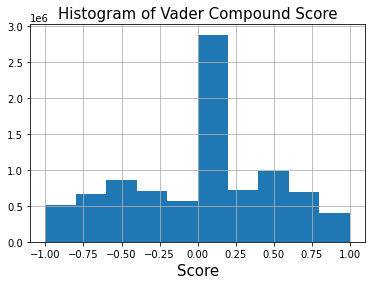

In [21]:
data.hist(column="vader_compound")
plt.xlabel("Score", size=15)
plt.title("Histogram of Vader Compound Score", size=15)

Text(0.5, 1.0, 'Histogram of Textblob Sentiment')

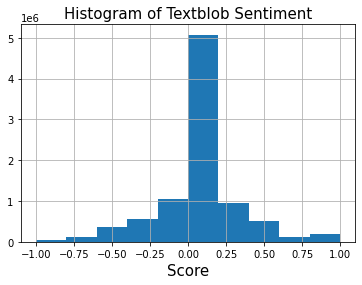

In [127]:
data.hist(column="textblob_sentiment")
plt.xlabel("Score", size=15)
plt.title("Histogram of Textblob Sentiment", size=15)

In [25]:
posts_pkl_path = os.path.join('..', '..', '..', "combined_bigquery_processed.pkl")
posts_df = pd.read_pickle(posts_pkl_path)

In [128]:
data = data.merge(posts_df, left_index = True, right_index = True, how = 'left')

In [129]:
data['date'] = pd.to_datetime(data['created_date'], format='%Y-%m-%d')
data['date'] = data['date'].dt.date

In [130]:
def plot_seven_day_moving_avg(df, col, title, y_axis, counts=False):
    
    if counts:
        compound_date = df.groupby(['date'])[col].size().reset_index()
        compound_date.set_index('date', inplace=True)
    else:
        compound_date = df.groupby(['date'])[col].mean().reset_index()
        compound_date.set_index('date', inplace=True)
    
    MOVING_AVG_WINDOW = 7
    compound_date['7_day_avg'] = (compound_date[col].
            rolling(window=MOVING_AVG_WINDOW).mean())
    
    plt.figure(figsize=(20,6))
    ax = compound_date['7_day_avg'].plot(linewidth=0.5)
    plt.ylabel(y_axis, size=15)
    plt.xlabel("Date", size=15)
    plt.title(title, size=18)
    # Major ticks every month.
    fmt_month = mdates.MonthLocator()
    ax.xaxis.set_major_locator(fmt_month)

    plt.axvline(dt.datetime(2019, 6, 26))

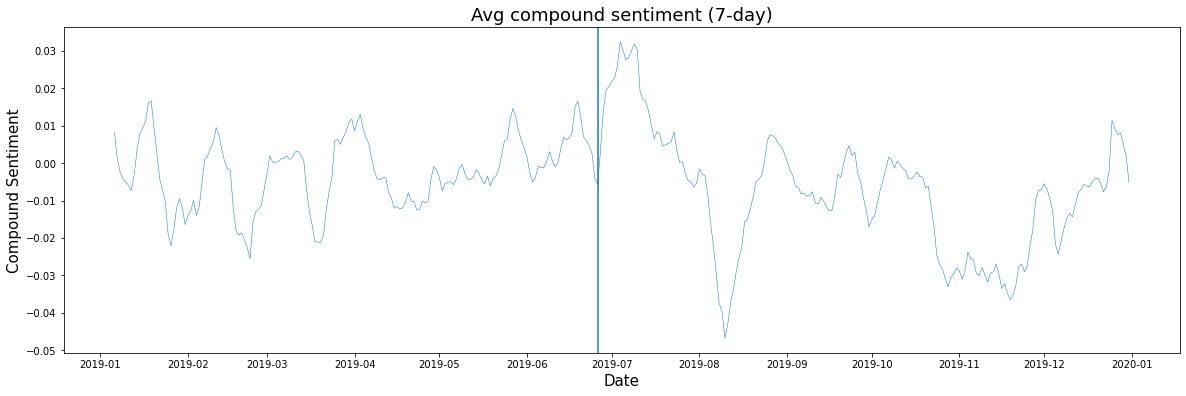

In [131]:
plot_seven_day_moving_avg(data, 'vader_compound', 'Avg compound sentiment (7-day)', 'Compound Sentiment')

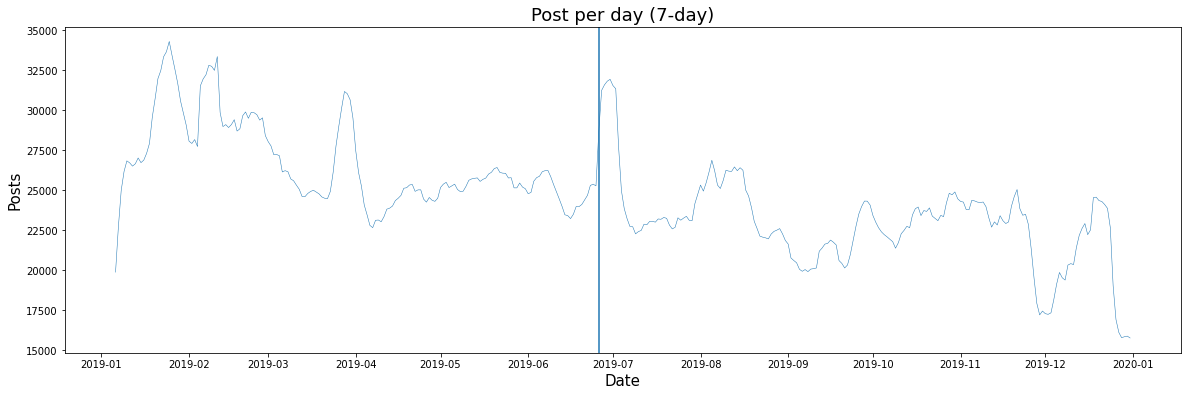

In [132]:
plot_seven_day_moving_avg(data, 'vader_compound', 'Post per day (7-day)', 'Posts', True)

# Evaluation

In [42]:
def create_count_data(df, group):
    """
    create dataframe of counts based on groupby
    :param df: pandas dataframe
    :param group: name of column to groupby
    :return: dataframe of counts for each group
    """
    counts = df.groupby(group).size().to_frame('count')
    counts.reset_index(inplace=True)
    return counts

def create_barplot(count_data, grouped_by_col, count_col, title):
    """
    create bar plot based on grouped_by_col
    """
    plt.figure(figsize=(20,6))
    p = sns.barplot(x=grouped_by_col, y=count_col,
                data=count_data)
    p.set_xticklabels(p.get_xticklabels(), rotation=40, ha="right")
    plt.ylabel("Count", size=15)
    plt.xlabel(grouped_by_col, size=15)
    plt.title(title, size=18)
    plt.show()

In [51]:
labels_1 = pd.read_csv("set_1.csv", index_col=0)
labels_1.head()
labels_1 = labels_1[["label"]]
labels_1.head()

,label
3605270,neutral
3844737,neutral
4113392,negative
3035067,neutral
3038117,negative


      label  count
0  negative  199  
1  neutral   241  
2  positive  51   


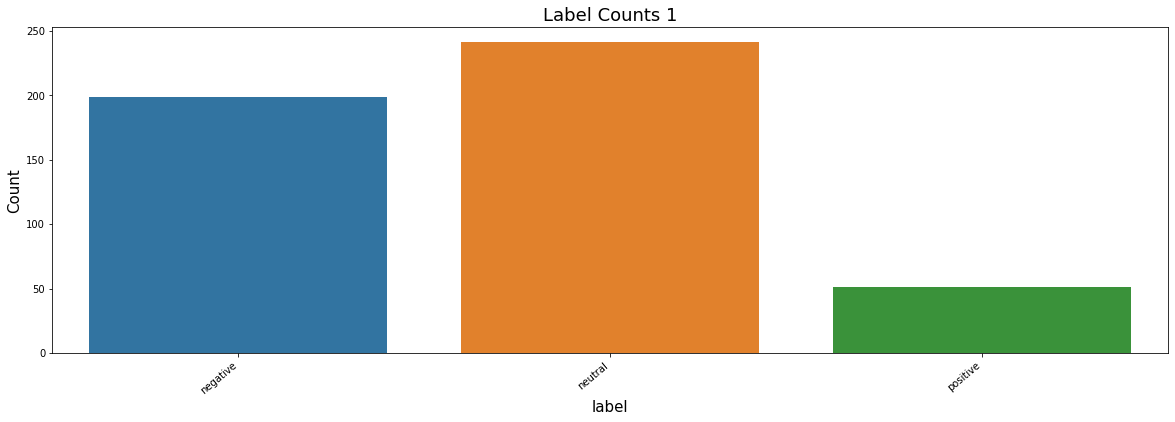

In [52]:
label_1_counts = create_count_data(labels_1, "label")
print(label_1_counts)
create_barplot(label_1_counts, "label", "count", "Label Counts 1")

In [66]:
labels_2 = pd.read_csv("set_3.csv", index_col=0)
labels_2.head()
labels_2 = labels_2[["label"]]
labels_2.head()

,label
2919497,0
3681067,1
2883915,-1
2579220,-1
3309177,0


   label  count
0 -1      128  
1  0      336  
2  1      36   


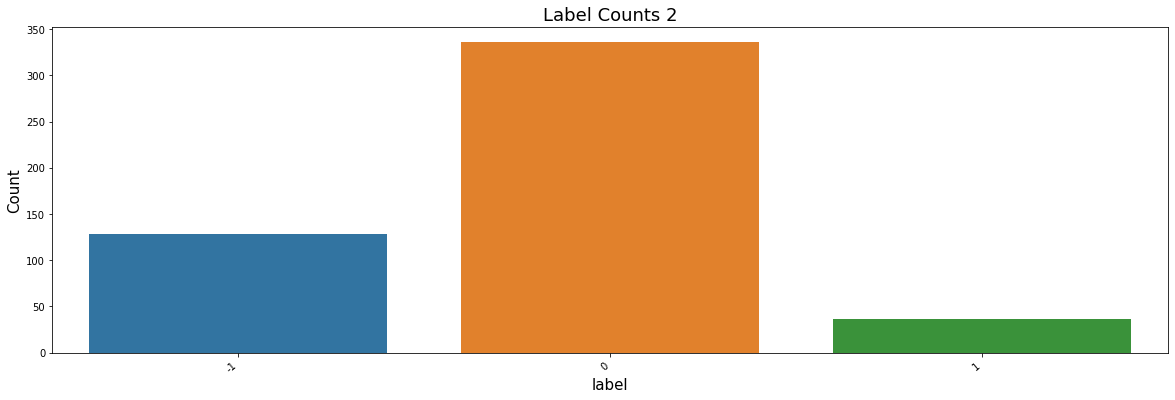

In [67]:
label_2_counts = create_count_data(labels_2, "label")
print(label_2_counts)
create_barplot(label_2_counts, "label", "count", "Label Counts 2")

In [68]:
labels_2["label"][labels_2["label"]==-1] = "negative"
labels_2["label"][labels_2["label"]==0] = "neutral"
labels_2["label"][labels_2["label"]==1] = "positive"

      label  count
0  negative  128  
1  neutral   336  
2  positive  36   


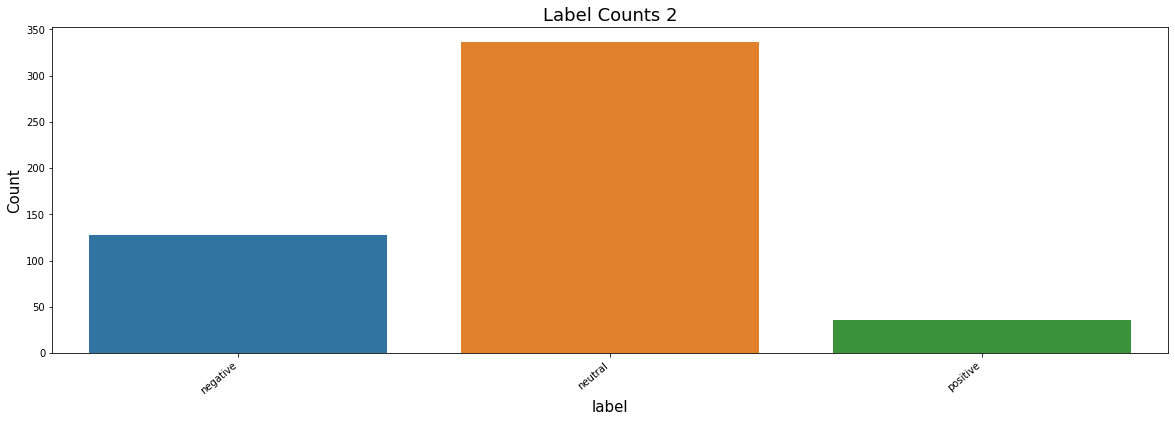

In [69]:
label_2_counts = create_count_data(labels_2, "label")
print(label_2_counts)
create_barplot(label_2_counts, "label", "count", "Label Counts 2")

In [71]:
print(f"len labels 1: {len(labels_1)}")
print(f"len labels 2: {len(labels_2)}")

len labels 1: 491
len labels 2: 500


In [76]:
labels = labels_1
labels = labels.append(labels_2)
print(f"len label combined: {len(labels)}")
print(f"len label index: {labels.index.nunique()}")

len label combined: 991
len label index: 991


In [133]:
labeled_data = labels.merge(data, left_index = True, right_index = True, how = 'left')
print(labeled_data.shape)
labeled_data.head()

(991, 34)


,label,orig_selftext,text_clean_space,text_clean_punc_lower,len_clean,vader_neg,vader_neu,vader_pos,vader_compound,textblob_sentiment,textblob_objectivity,selftext,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class,created_date,post_type,date
3605270,neutral,So much word salad!,So much word salad!,so much word salad,18,0.000,1.000,0.000,0.0000,0.200000,0.200000,So much word salad!,NaN,NaN,NaN,majorelle_blue,NaN,NaN,1561687965,t5_38unr,t3_c6djfn,t3_c6djfn,2,1571037655,0,0,es84xw0,The_Donald,NaN,NaN,NaN,2019-06-27,extant,2019-06-27
3844737,neutral,It's pronounced Milly - walk - ayyyy.,It's pronounced Milly - walk - ayyyy.,its pronounced milly walk ayyyy,33,0.000,1.000,0.000,0.0000,0.000000,0.000000,It's pronounced Milly - walk - ayyyy.,NaN,NaN,NaN,Badgermilk15,NaN,NaN,1561462608,t5_38unr,t3_c4vyhk,t1_eryud5t,1,1570896466,0,0,es01sy9,The_Donald,NaN,NaN,NaN,2019-06-25,extant,2019-06-25
4113392,negative,"#There are two kinds of people:\n\n**Criminals, and non-criminals**\n\nDemocrats support criminals. Many democrats themselves are criminals (looking at you Hillary). democrats want to have more crime, or to even ""legalize"" longstanding criminal acts. democrats want convicted felons voting. Democrats want more criminals coming into our country, and support criminal entry methods.\n\nIf you ask non-criminals about criminals they will say we should ""lock them up"". They think crime should be punished, and laws upheld.\n\nThat is pretty much the foundation of the political divide in the country right now.","#There are two kinds of people: **Criminals, and non-criminals** Democrats support criminals. Many democrats themselves are criminals (looking at you Hillary). democrats want to have more crime, or to even ""legalize"" longstanding criminal acts. democrats want convicted felons voting. Democrats want more criminals coming into our country, and support criminal entry methods. If you ask non-criminals about criminals they will say we should ""lock them up"". They think crime should be punished, and laws upheld. That is pretty much the foundation of the political divide in the country right now.",there are two kinds of people criminals and noncriminals democrats support criminals many democrats themselves are criminals looking at you hillary democrats want to have more crime or to even legalize longstanding criminal acts democrats want convicted felons voting democrats want more criminals coming into our country and support criminal entry methods if you ask noncriminals about criminals they will say we should lock them up they think crime should be punished and laws upheld that is pretty much the foundation of the political divide in the country right now,569,0.269,0.627,0.104,-0.9741,0.159524,0.492857,"#There are two kinds of people:\n\n**Criminals, and non-criminals**\n\nDemocrats support criminals. Many democrats themselves are criminals (looking at you Hillary). democrats want to have more crime, or to even ""legalize"" longstanding criminal acts. democrats want convicted felons voting. Democrats want more criminals coming into our country, and support criminal entry methods.\n\nIf you ask non-criminals about criminals they will say we should ""lock them up"". They think crime should be punished, and laws upheld.\n\nThat is pretty much the foundation of the political divide in the country right now.",NaN,NaN,NaN,Bulldog65,1776,NaN,1560527139,t5_38unr,t3_c0kjo4,t3_c0kjo4,12,1569900812,0,0,er5j7ce,The_Donald,NaN,NaN,MURICA,2019-06-14,extant,2019-06-14
3035067,neutral,She really is. ����,She really is.,she really is,14,0.000,1.000,0.000,0.0000,0.200000,0.200000,She really is. ����,NaN,NaN,NaN,InventorOfBacon,NaN,NaN,1563107088,t5_38unr,t3_ccyvg7,t1_etqixjw,6,1571987193,0,0,etqyjmz,The_Donald,NaN,NaN,NaN,2019-07-14,extant,2019-07-14
3038117,negative,"I know what you mean, but it is not up

Text(0.5, 1.0, 'Negative Labels: Vader Score')

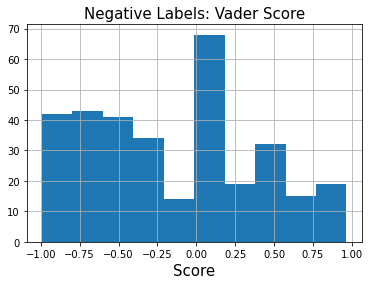

In [87]:
labeled_data[labeled_data["label"]=="negative"].hist(column="vader_compound")
plt.xlabel("Score", size=15)
plt.title("Negative Labels: Vader Score", size=15)


Text(0.5, 1.0, 'Negative Labels: Text Blob')

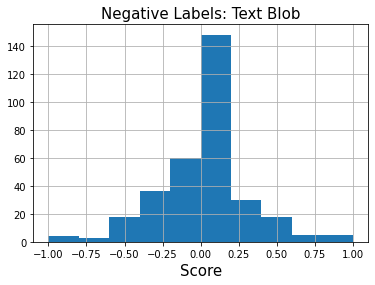

In [134]:
labeled_data[labeled_data["label"]=="negative"].hist(column="textblob_sentiment")
plt.xlabel("Score", size=15)
plt.title("Negative Labels: Text Blob", size=15)


Text(0.5, 1.0, 'Neutral Labels: Vader Score')

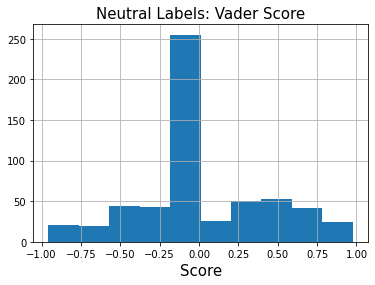

In [80]:
labeled_data[labeled_data["label"]=="neutral"].hist(column="vader_compound")
plt.xlabel("Score", size=15)
plt.title("Neutral Labels: Vader Score", size=15)

(-1.0, 1.0)

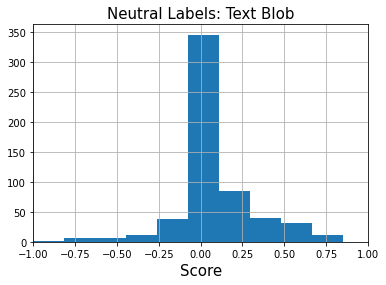

In [137]:
labeled_data[labeled_data["label"]=="neutral"].hist(column="textblob_sentiment")
plt.xlabel("Score", size=15)
plt.title("Neutral Labels: Text Blob", size=15)
plt.xlim([-1.0, 1.0])

(-1.0, 1.0)

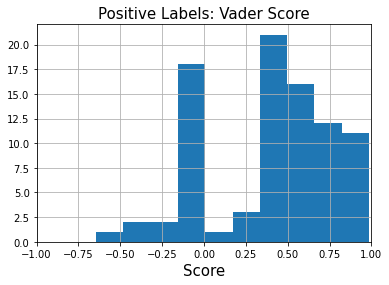

In [138]:
labeled_data[labeled_data["label"]=="positive"].hist(column="vader_compound")
plt.xlabel("Score", size=15)
plt.title("Positive Labels: Vader Score", size=15)
plt.xlim([-1.0, 1.0])

(-1.0, 1.0)

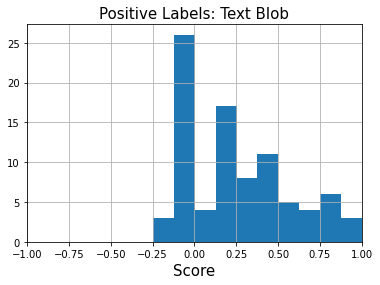

In [139]:
labeled_data[labeled_data["label"]=="positive"].hist(column="textblob_sentiment")
plt.xlabel("Score", size=15)
plt.title("Positive Labels: Text Blob", size=15)
plt.xlim([-1.0, 1.0])

In [143]:
neg_cutoff = -0.25
pos_cutoff = 0.25
labeled_data["VADER PRED_LABEL"] = np.where(labeled_data.vader_compound < neg_cutoff, 'negative',
                           np.where(labeled_data.vader_compound > pos_cutoff,'positive', 'neutral'))

labeled_data["TEXTBLOB PRED_LABEL"] = np.where(labeled_data.textblob_sentiment < neg_cutoff, 'negative',
                           np.where(labeled_data.textblob_sentiment > pos_cutoff,'positive', 'neutral'))

In [144]:
pd.crosstab(labeled_data["label"], labeled_data["VADER PRED_LABEL"], dropna=False)

VADER PRED_LABEL,negative,neutral,positive
label,,,
negative,155,90,82
neutral,117,301,159
positive,4,20,63


In [145]:
pd.crosstab(labeled_data["label"], labeled_data["TEXTBLOB PRED_LABEL"], dropna=False)

TEXTBLOB PRED_LABEL,negative,neutral,positive
label,,,
negative,46,237,44
neutral,27,456,94
positive,0,50,37


In [146]:
v_confusion = confusion_matrix(labeled_data["label"].values, labeled_data["VADER PRED_LABEL"].values)
print('VADER Confusion Matrix\n')
print(v_confusion)

VADER Confusion Matrix

[[155  90  82]
 [117 301 159]
 [  4  20  63]]


In [147]:
t_confusion = confusion_matrix(labeled_data["label"].values, labeled_data["TEXTBLOB PRED_LABEL"].values)
print('TEXTBLOB Confusion Matrix\n')
print(t_confusion)

TEXTBLOB Confusion Matrix

[[ 46 237  44]
 [ 27 456  94]
 [  0  50  37]]



Accuracy: 0.52

Weighted Precision: 0.63
Weighted Recall: 0.52
Weighted F1-score: 0.55


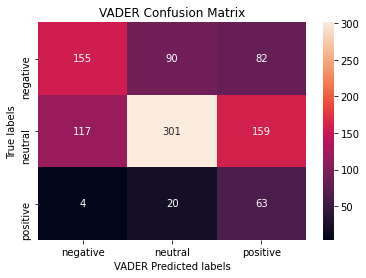

In [153]:
y_test = labeled_data["label"].values
y_pred = labeled_data["VADER PRED_LABEL"].values
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

ax= plt.subplot()
sns.heatmap(v_confusion,annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('VADER Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('VADER Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive']);
ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive']);


Accuracy: 0.54

Weighted Precision: 0.58
Weighted Recall: 0.54
Weighted F1-score: 0.50


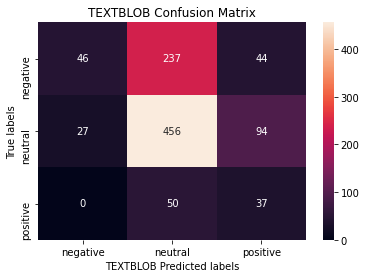

In [152]:
y_test = labeled_data["label"].values
y_pred = labeled_data["TEXTBLOB PRED_LABEL"].values
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

ax= plt.subplot()
sns.heatmap(t_confusion,annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('TEXTBLOB Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('TEXTBLOB Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive']);
ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive']);